In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
titanic_data=pd.read_csv('sample_data/train.csv')

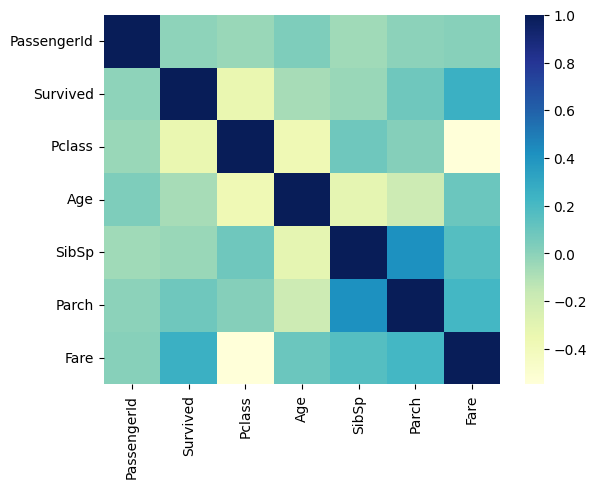

In [3]:
import seaborn as sns
sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")
plt.show()

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1, test_size=0.2 )
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived","Pclass","Sex"]]):
  strat_train_set=titanic_data.loc[train_indices]
  strat_test_set=titanic_data.loc[test_indices]

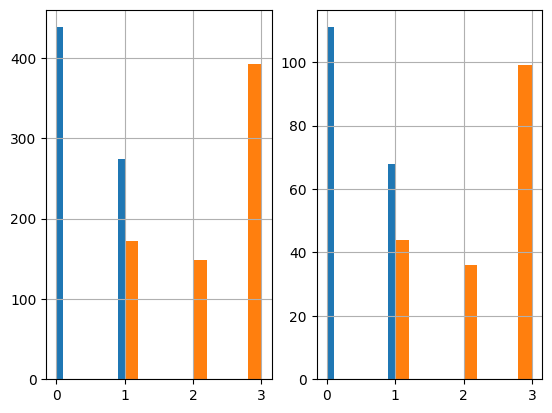

In [5]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()
# strat_train_set['Sex'].hist()
plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()
# strat_test_set['Sex'].hist()
plt.show()


In [6]:
from logging import setLoggerClass
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator,TransformerMixin):


  def transform(self,X):
    imputer=SimpleImputer(strategy='mean')
    X['Age']=imputer.fit_transform(X[['Age']])
    return X
  def fit(self,X,Y=None):
    return self



In [7]:
from sklearn.preprocessing import OneHotEncoder
class feature_encoder(BaseEstimator,TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    encoder=OneHotEncoder()
    matrix=encoder.fit_transform(X[['Embarked']]).toarray()


    column_names=["C","S","Q","N"]

    for i in range(len(matrix.T)):
      X[column_names[i]]=matrix.T[i]

    matrix=encoder.fit_transform(X[['Sex']]).toarray()
    column_names=["male","female"]
    for i in range(len(matrix.T)):
      X[column_names[i]]=matrix.T[i]

    return X


In [8]:
class FeatureDropper(BaseEstimator,TransformerMixin):
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    return X.drop(['Name','Ticket','Cabin','Embarked','Sex','N'],axis=1,errors="ignore")

In [9]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline([
    ('age_imputer',AgeImputer()),
    ('feature_encoder',feature_encoder()),
    ('feature_dropper',FeatureDropper())
])

In [10]:
strat_train_set=pipeline.fit_transform(strat_train_set)


In [11]:
strat_train_set.info()


<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 628 to 97
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  male         712 non-null    float64
 11  female       712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [12]:
from sklearn.preprocessing import StandardScaler
X=strat_train_set.drop(['Survived'],axis=1)
y=strat_train_set['Survived']

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
y_data=y.to_numpy()

In [13]:
X_data

array([[ 0.73410082,  0.82789342, -0.26790016, ...,  0.60547724,
        -0.73561236,  0.73561236],
       [-1.05348476, -1.56828591,  2.00245148, ..., -1.65158975,
        -0.73561236,  0.73561236],
       [-1.70709535,  0.82789342, -0.19222178, ...,  0.60547724,
         1.35941164, -1.35941164],
       ...,
       [ 0.52935534, -0.37019624,  0.33752694, ...,  0.60547724,
         1.35941164, -1.35941164],
       [ 0.63960291, -1.56828591,  0.41320533, ..., -1.65158975,
        -0.73561236,  0.73561236],
       [-1.35666557, -1.56828591, -0.49493533, ..., -1.65158975,
        -0.73561236,  0.73561236]])

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf=RandomForestClassifier()
param_grid=[
    {"n_estimators":[10,100,200,500],"max_depth":[None,5,10],"min_samples_split":[2,3,4]}
    ]
grid_search=GridSearchCV(clf,param_grid,cv=3,scoring="accuracy",return_train_score=True)
grid_search.fit(X_data,y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [19]:
final_clf=grid_search.best_estimator_

In [20]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3, n_estimators=500)

In [21]:
strat_test_set=pipeline.fit_transform(strat_test_set)


In [22]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,male,female
308,309,0,2,30.000000,1,0,24.0000,1.0,0.0,0.0,0.0,1.0
635,636,1,2,28.000000,0,0,13.0000,0.0,0.0,1.0,1.0,0.0
215,216,1,1,31.000000,1,0,113.2750,1.0,0.0,0.0,1.0,0.0
279,280,1,3,35.000000,1,1,20.2500,0.0,0.0,1.0,1.0,0.0
849,850,1,1,30.323586,1,0,89.1042,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,1,3,30.323586,0,0,7.7750,0.0,0.0,1.0,0.0,1.0
185,186,0,1,30.323586,0,0,50.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
226,227,1,2,19.000000,0,0,10.5000,0.0,0.0,1.0,0.0,1.0


In [25]:
X_test=strat_test_set.drop(['Survived'],axis=1)
y_test=strat_test_set['Survived']

scaler=StandardScaler()
X_data_test=scaler.fit_transform(X_test)
y_data_test=y_test.to_numpy()

In [26]:
final_clf.score(X_data_test,y_data_test)

0.8268156424581006

In [28]:
final_data=pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,male,female
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0
